In [3]:
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径


In [4]:
# 读取Excel文件
excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据\\数据-时间戳.xlsx'
df_sheet = pd.read_excel(excel_path, sheet_name='原始数据-剔除温度异常值') 
print(df_sheet.info())
print(df_sheet.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16252 entries, 0 to 16251
Data columns (total 42 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   铁水时间戳   16252 non-null  float64
 1   P       16252 non-null  float64
 2   S       16252 non-null  float64
 3   MN      16252 non-null  float64
 4   SI      16252 non-null  float64
 5   V       16252 non-null  float64
 6   TI      16252 non-null  float64
 7   As      16252 non-null  float64
 8   铁口1时间戳  7216 non-null   float64
 9   铁口1温度   7216 non-null   float64
 10  铁口2时间戳  2018 non-null   float64
 11  铁口2温度   2018 non-null   float64
 12  铁口3时间戳  7507 non-null   float64
 13  铁口3温度   7507 non-null   float64
 14  主参数时间戳  7453 non-null   float64
 15  富氧率     7453 non-null   float64
 16  透气性指数   7453 non-null   float64
 17  CO      7453 non-null   float64
 18  H2      7453 non-null   float64
 19  CO2     7453 non-null   float64
 20  标准风速    7453 non-null   float64
 21  富氧流量    7453 non-null   float64
 22

In [5]:
# 定义输入输出参数
input_term = ['富氧流量', '冷风流量', '热风温度', '设定喷煤量']
output_term = ['铁口1温度', 'SI']
time_term= '主参数时间戳'


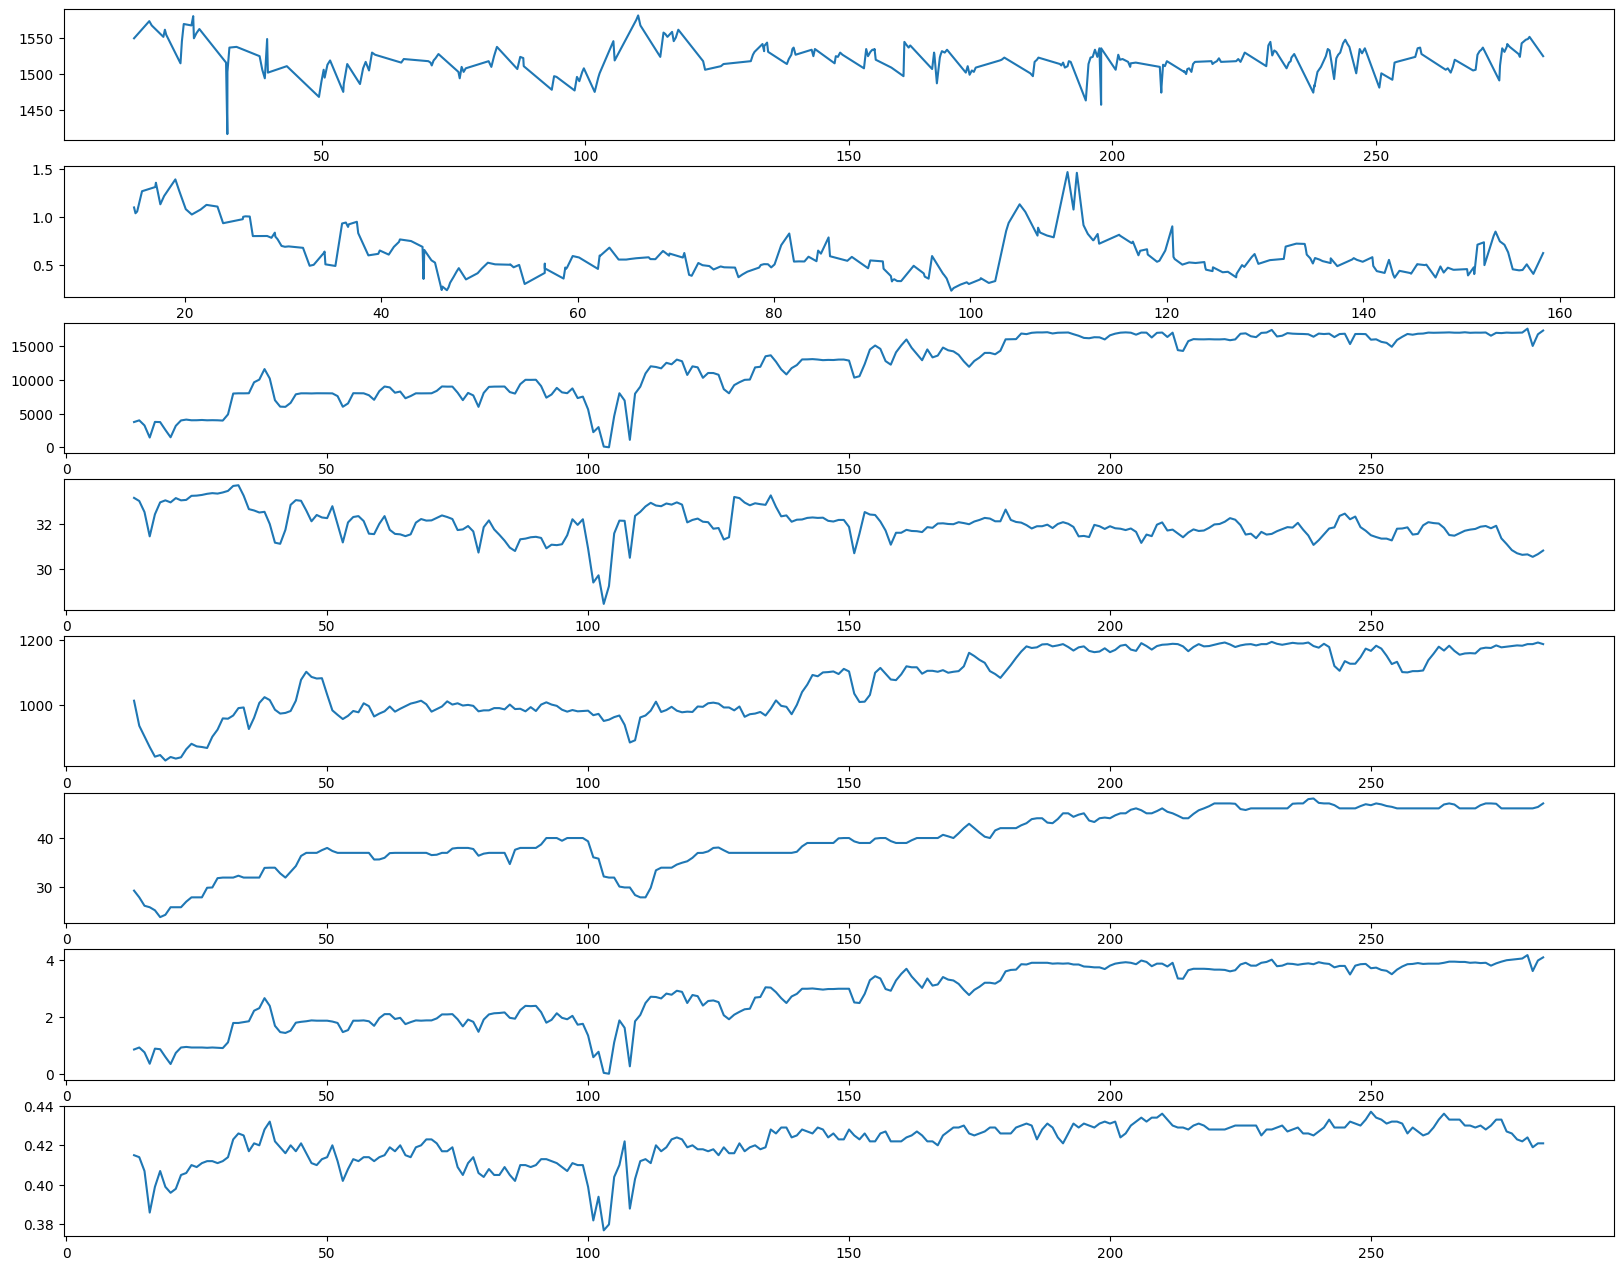

In [9]:

length1 = 270
start1 = 0

index = range(start1, start1+length1+1, 1)


plt.figure(figsize=(20, 20))

plt.subplot(10, 1, 1)
plt.plot(df_sheet['铁口1时间戳'][index],df_sheet['铁口1温度'][index])
plt.subplot(10, 1, 2)
plt.plot(df_sheet['铁水时间戳'][index],df_sheet['SI'][index])
plt.subplot(10, 1, 3)
plt.plot(df_sheet['主参数时间戳'][index],df_sheet['富氧流量'][index])
plt.subplot(10, 1, 4)
plt.plot(df_sheet['主参数时间戳'][index],df_sheet['冷风流量'][index])
plt.subplot(10, 1, 5)
plt.plot(df_sheet['主参数时间戳'][index],df_sheet['热风温度'][index])
plt.subplot(10, 1, 6)
plt.plot(df_sheet['主参数时间戳'][index],df_sheet['设定喷煤量'][index])
plt.subplot(10, 1, 7)
plt.plot(df_sheet['主参数时间戳'][index],df_sheet['富氧率'][index])
plt.subplot(10, 1, 8)
plt.plot(df_sheet['主参数时间戳'][index],df_sheet['冷风压力'][index])


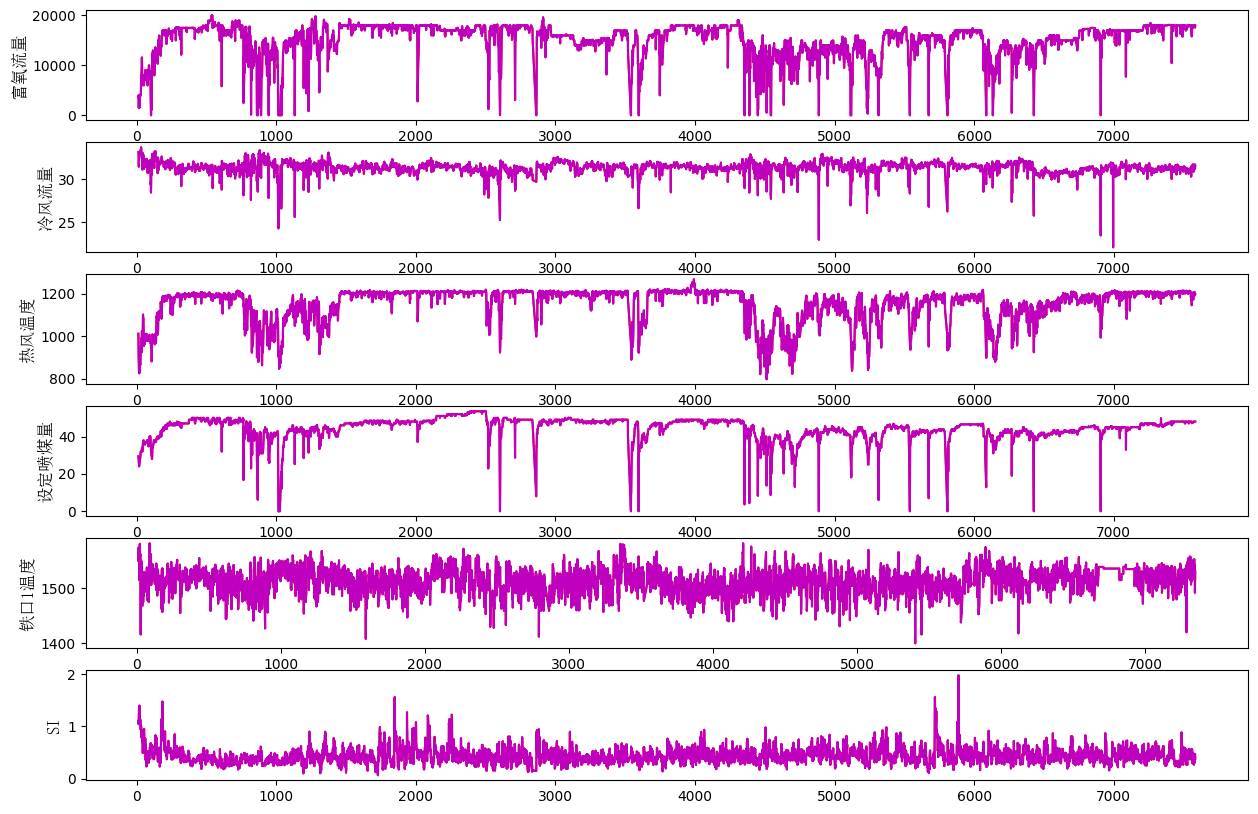

In [7]:
# 异常数据处理-处理前后对比
# 创建数据框副本以避免修改原始数据
df_sheet_process = df_sheet.copy()

# 定义一个函数，用中位数替换异常值
def replace_outliers_with_median(series):
    # 计算列的中位数
    median_value = series.median()
    # 检测异常值
    outliers = (series - median_value).abs() > 3.0 * series.std()  # 使用标准差作为阈值
    # 使用中位数替换异常值
    series[outliers] = median_value
# 画出数据
def plot_subplot(data_x,data_y_yuan,data_y,column):
    plt.plot(data_x,data_y_yuan,'r-')
    plt.plot(data_x,data_y,'m-')
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签
    # 使用中文标签


# 对指定列应用替代异常值的函数
# replace_outliers_with_median(df_sheet_process[input_term[0]])
# replace_outliers_with_median(df_sheet_process[input_term[1]])
# replace_outliers_with_median(df_sheet_process[output_term[0]])
# replace_outliers_with_median(df_sheet_process[output_term[1]])
# replace_outliers_with_median(df_sheet_process[output_term[2]])
# replace_outliers_with_median(df_sheet_process[output_term[3]])

plt.figure(figsize=(15, 10))
for idx, column in enumerate(input_term+output_term):
    
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_process[time_term].values,df_sheet[column].values,df_sheet_process[column].values,column)




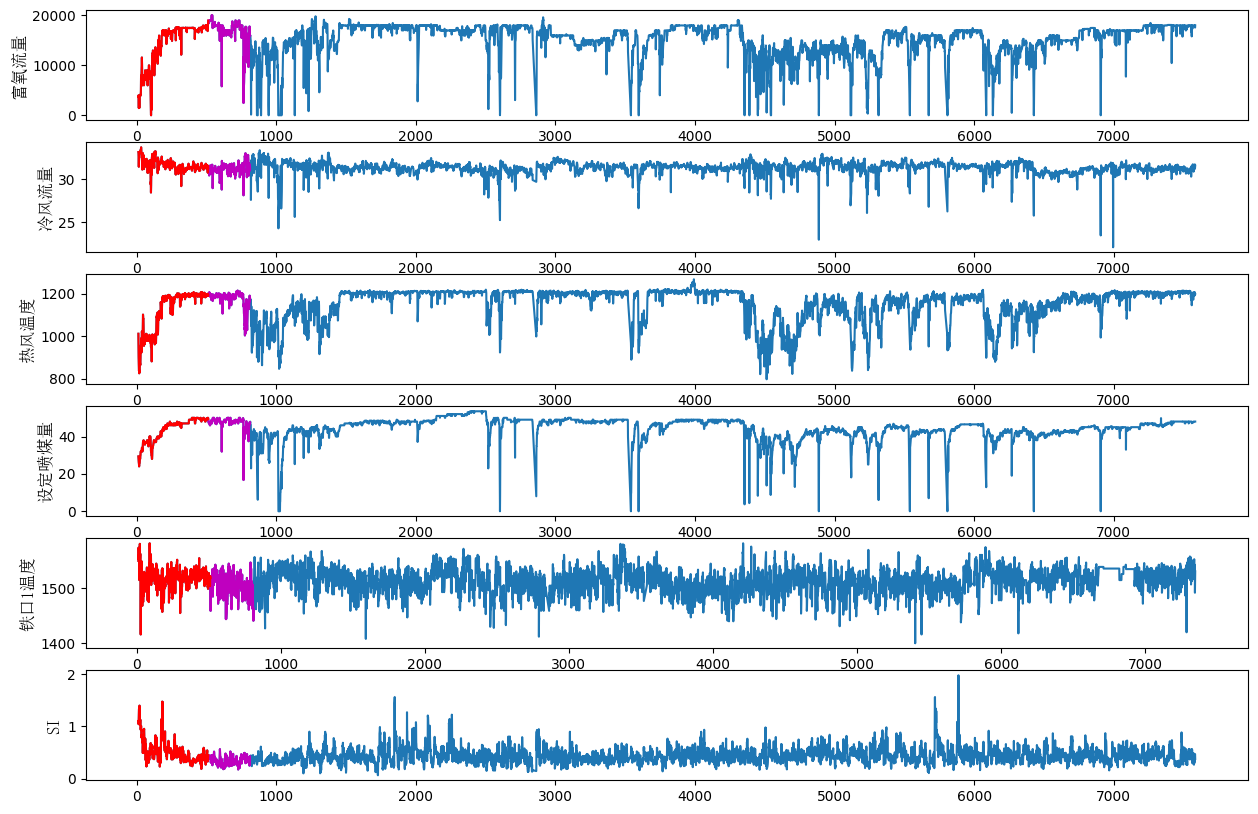

In [8]:
# 画出选取的数据
def plot_subplot(data_x,data_y,column,index_predict,index_gaolu):
    plt.plot(data_x,data_y,'-')
    plt.plot(data_x[index_gaolu],data_y[index_gaolu],'m-')
    plt.plot(data_x[index_predict],data_y[index_predict],'r-')
    
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签

# index = range(1300, 2500, 1)
# index = range(4500, 6550, 1)

# index = range(5000, 5610, 1)
    
# length = 3000
# start1 = 200
# start2 = 4000   829

length1 = 500
start1 = 0
length2 = 300
start2 = 500


# length = 280
# start1 = 3550
# start2 = 4000
index_predict   = range(start1, start1+length1+1, 1)
index_gaolu     = range(start2, start2+length2+1, 1)
# index = range(1, 7572, 1)


plt.figure(figsize=(15, 10))
for idx, column in enumerate(input_term+output_term):
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_process[time_term].values,df_sheet_process[column].values,column,index_predict,index_gaolu)
